In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import torch
import matplotlib.pyplot as plt
import io
from contextlib import redirect_stdout
import fastmri
from datetime import datetime
from torchsummary import summary
from pathlib import Path

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
import torch.nn as nn
from torch.optim import Adam , RMSprop

from utils.mri_data import SliceDataset
from torch.optim.lr_scheduler import StepLR
from utils.data_transform import DataTransform_Diffusion , DataTransform_UNet , XAITransform
from utils.sample_mask import RingMaskFunc, RandomMaskGaussian
from utils.misc import *
from utils.XAI_utils import *
from help_func import print_var_detail

from diffusion.kspace_diffusion import KspaceDiffusion
from utils.training_utils import UNetTrainer, train_unet
from utils.diffusion_train import Trainer
from utils.testing_utils import reconstruct_multicoil, recon_slice_unet
from net.unet.unet_supermap import Unet 
from net.unet.improved_unet import UnetModel
from utils.logger_utils import Logger
from utils.evaluation_utils import *

from utils.visualize_utils import plot_reconstruction_vs_ground_truth, plot_full_reconstruction_4panel, visualize_data_sample,generate_ring_masks_fixed_step, plot_ring_masks
import torch.nn.functional as F

/eng/home/koushani/Documents/MR_KReconstruction/K-SpaceColdDIffusion/utils/testing_utils.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# https://claude.ai/public/artifacts/9cc4caec-3b72-4560-a8ba-f7ec32fe220a

def l1_image_loss(pred, target):
    """
    Computes L1 (Mean Absolute Error) loss between predicted and target images.
    Args:
        pred: [B, 1, H, W] - Predicted image
        target: [B, 1, H, W] - Ground truth image
    Returns:
        Scalar L1 loss
    """
    return F.l1_loss(pred, target)

In [3]:
print(torch.__version__)
gpu = 0
# Check if specified GPU is available, else default to CPU
if torch.cuda.is_available():
    try:
        device = torch.device(f"cuda:{gpu}")
        # Test if the specified GPU index is valid
        _ = torch.cuda.get_device_name(device)
    except AssertionError:
        print(f"GPU {gpu} is not available. Falling back to GPU 0.")
        device = torch.device("cuda:0")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

2.7.0


In [4]:
idx_case = 8 # Select the case you want to visualize
num_rings = 20
batch_no = 0
n_perturbations = 100
path_dir_train = '/data2/users/koushani/FAST_MRI_data/MRI_Brain/multicoil_train'
# # # save settings
exp_id = "0607-19-17-48" # datetime.now().strftime("%m%d-%H-%M-%S")
PATH_MODEL = f'/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask'
save_folder=PATH_MODEL
create_path(PATH_MODEL)
ring_mask_path = pathlib.Path(PATH_MODEL) / "ring_mask" 

Path already exists.


In [5]:
EXP_PATH = pathlib.Path(PATH_MODEL) / exp_id  # Full path with timestamp

# # Ensure experiment directory exists
EXP_PATH.mkdir(parents=True, exist_ok=True)



# Define subfolders inside the experiment path
LOGS_PATH = EXP_PATH / "logs"
MODELS_PATH = EXP_PATH / "models" 

# Create necessary subdirectories
LOGS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)
create_path(PATH_MODEL)

# model_load_path = EXP_PATH / "models" / "model_final.pt"
# # # construct diffusion model
# perturbations_output_dir= f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_l1_Adam_s300_lr_1e-05/0418-15-26-15/XAI/PERTURBATIONS_REVERSE_{num_rings}/"
# test_output_dir= f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_l1_Adam_s300_lr_1e-05/0418-15-26-15/XAI/GRADCAM_VISUALIZATION_PROGRESIVE_{num_rings}/"
# EXP_PATH.mkdir(parents=True, exist_ok=True)

# Now safe to pass to Logger
logger = Logger(logging_level="INFO", exp_path=EXP_PATH, use_wandb=False)
    
path_dir_test = '/data2/users/koushani/FAST_MRI_data/MRI_Brain/multicoil_train'
img_mode = 'fastmri'  # 'fastmri' or 'B1000'
bhsz = 16
NUM_EPOCH = 100
img_size = 320


Path already exists.


In [6]:
mask_path = "/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_mask/ring_mask_1.npy"
mask_func = RingMaskFunc(mask_path)

In [7]:
def get_valid_sample(dataset, start=0):
    for idx in range(start, len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            return idx, sample
    raise ValueError("No valid sample found.")

In [8]:
transform = DataTransform_UNet(mask_func=mask_func, combine_coil = False)
# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=transform,
    challenge='multicoil',
    num_skip_slice=5,
)

In [9]:
class ValidDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (x, y, m)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def get_valid_samples(dataset, num_samples=100, start=0):
    valid_samples = []
    idx = start

    while len(valid_samples) < num_samples and idx < len(dataset):
        sample = dataset[idx]
        if sample is not None:
            valid_samples.append(sample)  # (x, y, m)
        idx += 1

    if len(valid_samples) < num_samples:
        raise ValueError(f"Only {len(valid_samples)} valid samples found, expected {num_samples}.")

    return valid_samples

In [10]:
# Extract 2000 valid samples from dataset_train
valid_samples = get_valid_samples(dataset_train, num_samples=2000)

# Create a new dataset using these preloaded samples
dataset_train_final = ValidDataset(valid_samples)

[DEBUG] Input shape  (x): torch.Size([1, 320, 320])
[DEBUG] Target shape (y): torch.Size([1, 320, 320])
[DEBUG] Mask shape   : torch.Size([1, 320, 320])


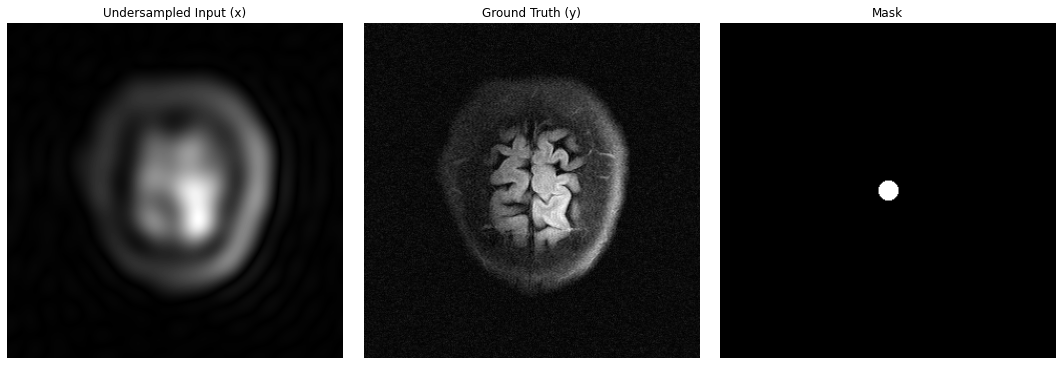

In [11]:
# Pick an index to inspect
sample_index = 20

# Retrieve the sample from the dataset
x, y, mask = dataset_train_final[sample_index]  # Assumes __getitem__ returns (input, target, mask)

print(f"[DEBUG] Input shape  (x): {x.shape}")
print(f"[DEBUG] Target shape (y): {y.shape}")
print(f"[DEBUG] Mask shape   : {mask.shape}")

# Plot input (undersampled), ground truth, and mask side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].numpy(), cmap='gray')
axs[0].set_title("Undersampled Input (x)")

axs[1].imshow(y[0].numpy(), cmap='gray')
axs[1].set_title("Ground Truth (y)")

axs[2].imshow(mask[0].numpy(), cmap='gray')
axs[2].set_title("Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# 90/10 split
n_total = len(dataset_train_final)
n_train = int(0.9 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset_train_final,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)


In [13]:
# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=bhsz, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=bhsz, shuffle=False)

In [14]:
logger.log(f"Using device: {device}")
logger.log(f"len dataloader train: {len(dataloader_train)}")
logger.log(f"len dataloader test: {len(dataloader_val)}")


logger.log("\n----------------TRAINING DATA--------------------")
for i, (x, y, m) in enumerate(dataloader_train):
    logger.log(f"\nSample {i+1}:")
    logger.log(f"  Input (x) shape : {x.shape}")
    logger.log(f"  Target (y) shape: {y.shape}")
    logger.log(f"  Mask shape      : {m.shape}")
    break

2025-07-18 13:26:42,356 - INFO - Using device: cuda:0
2025-07-18 13:26:42,357 - INFO - len dataloader train: 113
2025-07-18 13:26:42,358 - INFO - len dataloader test: 13
2025-07-18 13:26:42,358 - INFO - 
----------------TRAINING DATA--------------------
2025-07-18 13:26:42,362 - INFO - 
Sample 1:
2025-07-18 13:26:42,362 - INFO -   Input (x) shape : torch.Size([16, 1, 320, 320])
2025-07-18 13:26:42,363 - INFO -   Target (y) shape: torch.Size([16, 1, 320, 320])
2025-07-18 13:26:42,364 - INFO -   Mask shape      : torch.Size([16, 1, 320, 320])


In [15]:
def visualize_sample_by_index(dataset, sample_index):
    """
    Visualize a single sample from the dataset by index.

    Parameters:
    - dataset: the MRI dataset (e.g., SliceDataset instance)
    - sample_index: integer index of the sample to visualize
    """
    # Fetch the sample
    x, y, m = dataset[sample_index]  # shape: [1, H, W]

    # Convert to NumPy arrays for plotting
    x_img = x.squeeze().cpu().numpy()
    y_img = y.squeeze().cpu().numpy()
    m_img = m.squeeze().cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Undersampled Input")
    axs[0].axis('off')

    axs[1].imshow(y_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(m_img, cmap='gray')
    axs[2].set_title("Undersampling Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

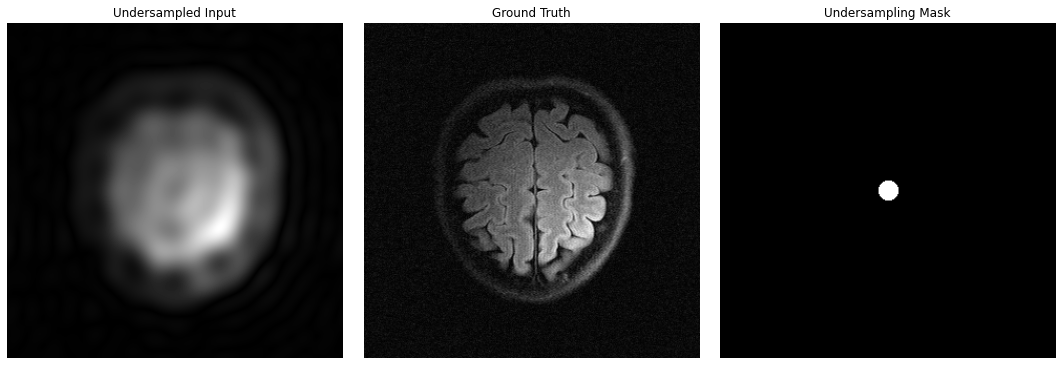

In [16]:
# Pick sample index (e.g., 10)
sample_index = 10

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)

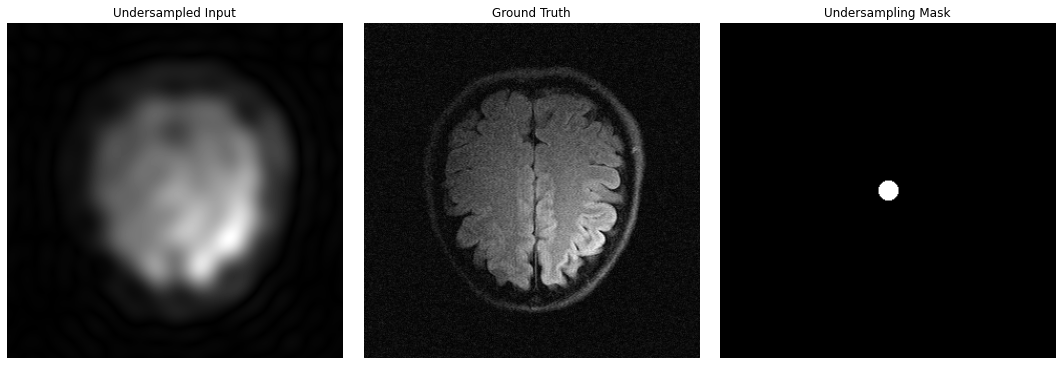

In [17]:
# Pick sample index (e.g., 10)
sample_index = 8

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)

In [18]:
model_load_path =  f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0607-19-17-48/models/model_final.pt"
output_dir =f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0607-19-17-48/VISUALIZATIONS"
npy_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.npy"
png_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.png"
npy_path = os.path.join(output_dir, npy_filename)
png_save_path = os.path.join(output_dir, png_filename)

In [19]:
model = Unet(
dim=64,
channels=1,         # input is single-channel masked image
out_dim=1,          # output is single-channel reconstructed image
dim_mults=(1, 2, 3, 4),
self_condition=False
).to(device)

In [20]:
learning_rate = 1e-5  # start here

In [21]:
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])


In [22]:
# use RMSprop as optimizer
weight_decay = 0.0
optimizer = Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [23]:
# Create a buffer to capture output
buffer = io.StringIO()
with redirect_stdout(buffer):
    summary(model, input_size=(1, 320, 320), batch_size=1, device="cuda" if torch.cuda.is_available() else "cpu")

# Get the string output
summary_str = buffer.getvalue()
channels = 1
H = 320
W = 320
# Now log it
logger.log("Model Summary:\n" + summary_str)
input_size=(channels, H, W)
summary(model, input_size=(1, 320, 320), batch_size=1, device="cuda" if torch.cuda.is_available() else "cpu")

2025-07-18 13:26:43,569 - INFO - Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 320, 320]           3,200
WeightStandardizedConv2d-2          [1, 64, 320, 320]          36,928
         GroupNorm-3          [1, 64, 320, 320]             128
              SiLU-4          [1, 64, 320, 320]               0
             Block-5          [1, 64, 320, 320]               0
WeightStandardizedConv2d-6          [1, 64, 320, 320]          36,928
         GroupNorm-7          [1, 64, 320, 320]             128
              SiLU-8          [1, 64, 320, 320]               0
             Block-9          [1, 64, 320, 320]               0
         Identity-10          [1, 64, 320, 320]               0
      ResnetBlock-11          [1, 64, 320, 320]               0
WeightStandardizedConv2d-12          [1, 64, 320, 320]          36,928
        GroupNorm-13          [1, 64

In [24]:
# --------------------------
# 3. Loss function
# --------------------------


loss_fn = l1_image_loss  # expects [B, 1, H, W]


# --------------------------
# 3. Scheduler
# --------------------------
step_size = 12
lr_gamma = 0.1 # change in learning rate
scheduler = StepLR(optimizer, step_size, lr_gamma)

In [25]:
grad_cam_path= EXP_PATH / "XAI" / f"ring_1_Top16Channel_Grad-CAM_ups_plot.png"
grad_cam_path.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

In [26]:
# Get one reconstruction
idx_case = 20

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,) 

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 1.5991963664419018e-05 max: 0.9999851584434509 mean: 0.1577964872121811
y_pred (raw model output) stats: min: 0.021396905183792114 max: 0.8970190286636353
Z-score mean: tensor([0.2185, 0.1263, 0.2039, 0.1981, 0.0916, 0.1222, 0.1316, 0.1253, 0.2313,
        0.1525, 0.1459, 0.1425, 0.1143, 0.0964, 0.1916, 0.2326],
       device='cuda:0')
Z-score std: tensor([0.1889, 0.1814, 0.2174, 0.2381, 0.

/eng/home/koushani/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/eng/home/koushani/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


[Saved] /data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_1_BrainData_model_FullPanel_reconstruction_plot.png


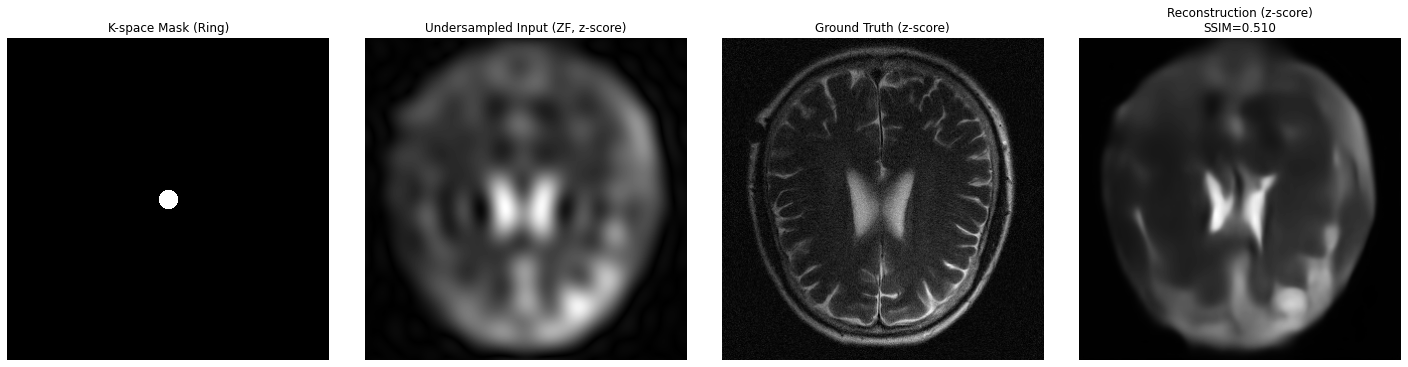

In [27]:
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_1_BrainData_model_FullPanel_reconstruction_plot.png")

[Saved] /data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_1_sample_20_BrainData_model_FullPanel_reconstruction_plot.png


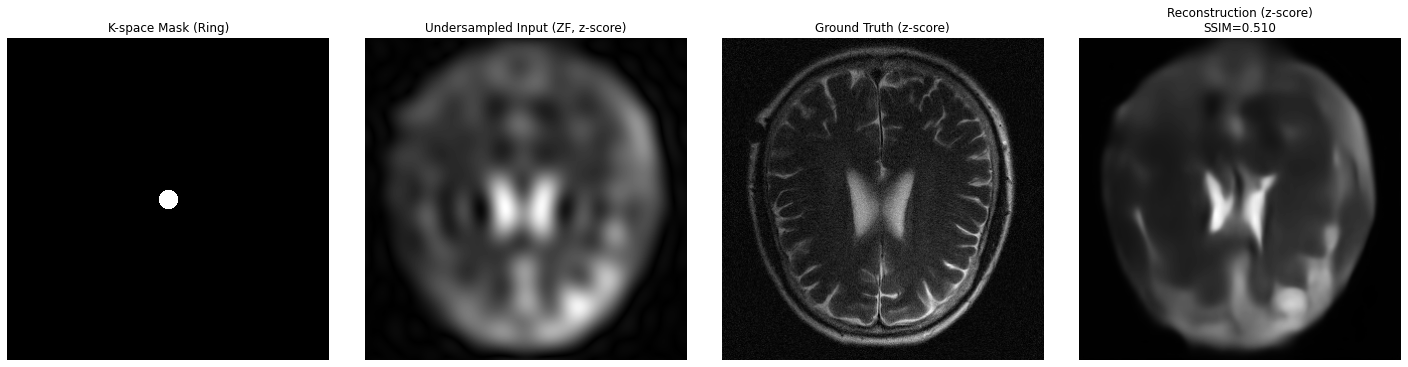

In [28]:
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_1_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")

In [29]:
mask_path = "/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_mask/ring_mask_2.npy"
mask_func = RingMaskFunc(mask_path)

[DEBUG] Input shape  (x): torch.Size([1, 320, 320])
[DEBUG] Target shape (y): torch.Size([1, 320, 320])
[DEBUG] Mask shape   : torch.Size([1, 320, 320])


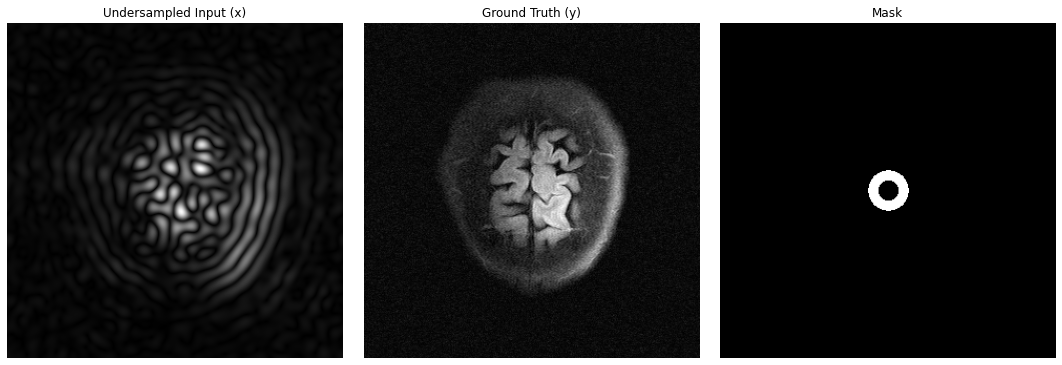

2025-07-18 13:29:22,829 - INFO - Using device: cuda:0
2025-07-18 13:29:22,830 - INFO - len dataloader train: 113
2025-07-18 13:29:22,830 - INFO - len dataloader test: 13
2025-07-18 13:29:22,831 - INFO - 
----------------TRAINING DATA--------------------
2025-07-18 13:29:22,833 - INFO - 
Sample 1:
2025-07-18 13:29:22,834 - INFO -   Input (x) shape : torch.Size([16, 1, 320, 320])
2025-07-18 13:29:22,834 - INFO -   Target (y) shape: torch.Size([16, 1, 320, 320])
2025-07-18 13:29:22,835 - INFO -   Mask shape      : torch.Size([16, 1, 320, 320])


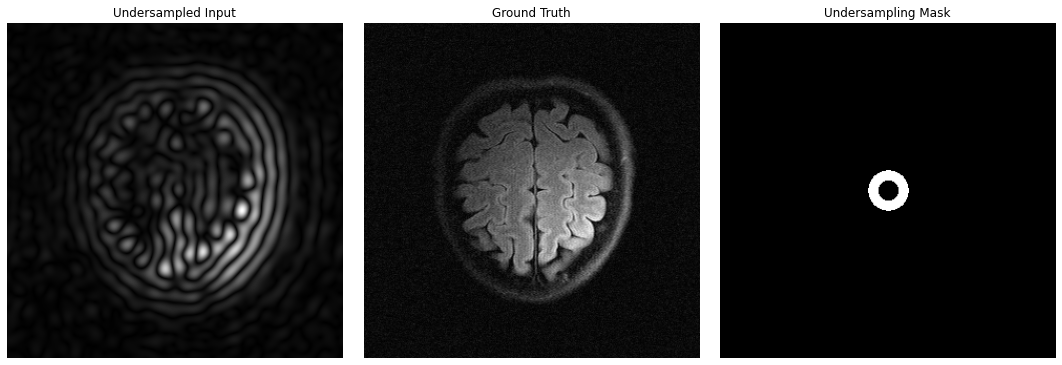

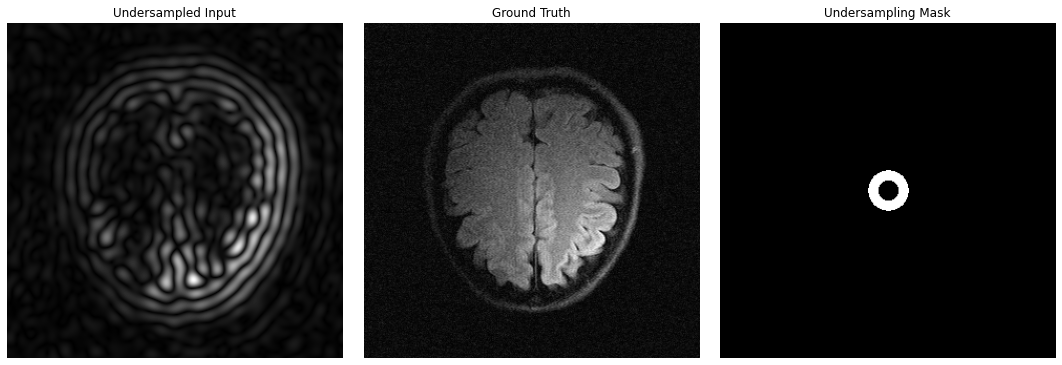

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 1.815659379644785e-05 max: 0.9999347925186157 mean: 0.10938659310340881
y_pred (raw model output) stats: min: 0.01482895016670227 max: 0.989678144454956
Z-score mean: tensor([0.0832, 0.1636, 0.1316, 0.0923, 0.0954, 0.0903, 0.1782, 0.1081, 0.1022,
        0.0915, 0.0749, 0.0817, 0.1391, 0.1045, 0.1179, 0.0956],
       device='cuda:0')
Z-score std: tensor([0.1042, 0.1401, 0.1415, 0.1056, 0.1148, 0.1072, 0.1567, 0.1265, 0.1247,
        0.1054, 0.0982, 0.1082, 0.1100, 0.1173, 0.1330, 0.1172],
       device='cuda:0')
tg (after z-score) stats: min: -1.2551345825195312 max: 9.4249906539917
pred (after z-score) stats: min: -0.8596976

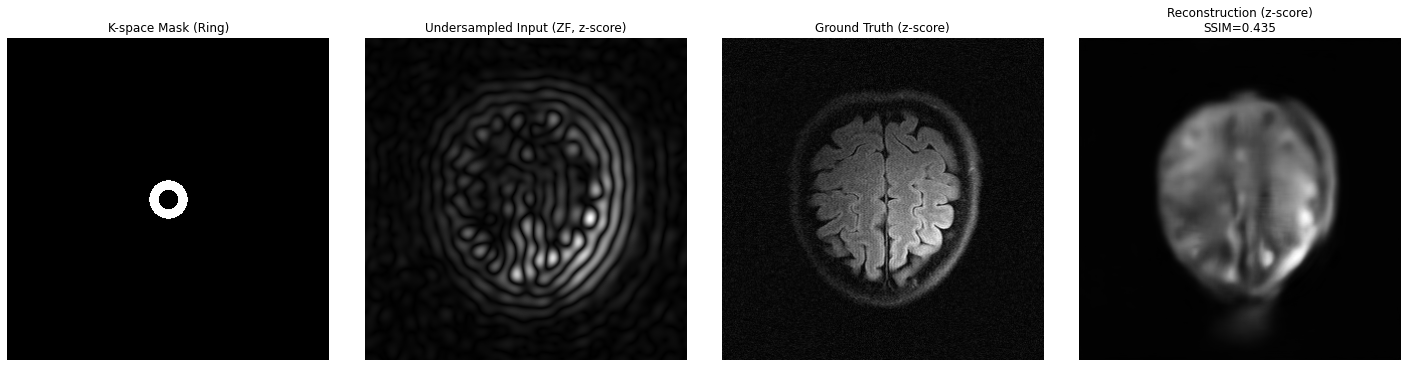

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 1.6495583622599952e-05 max: 0.9999583959579468 mean: 0.09714753180742264
y_pred (raw model output) stats: min: 0.013083375990390778 max: 0.9029666185379028
Z-score mean: tensor([0.1392, 0.0945, 0.0741, 0.0673, 0.0939, 0.1203, 0.0896, 0.1135, 0.1330,
        0.0639, 0.0800, 0.0726, 0.1075, 0.0791, 0.1202, 0.1057],
       device='cuda:0')
Z-score std: tensor([0.1402, 0.1010, 0.0822, 0.0946, 0

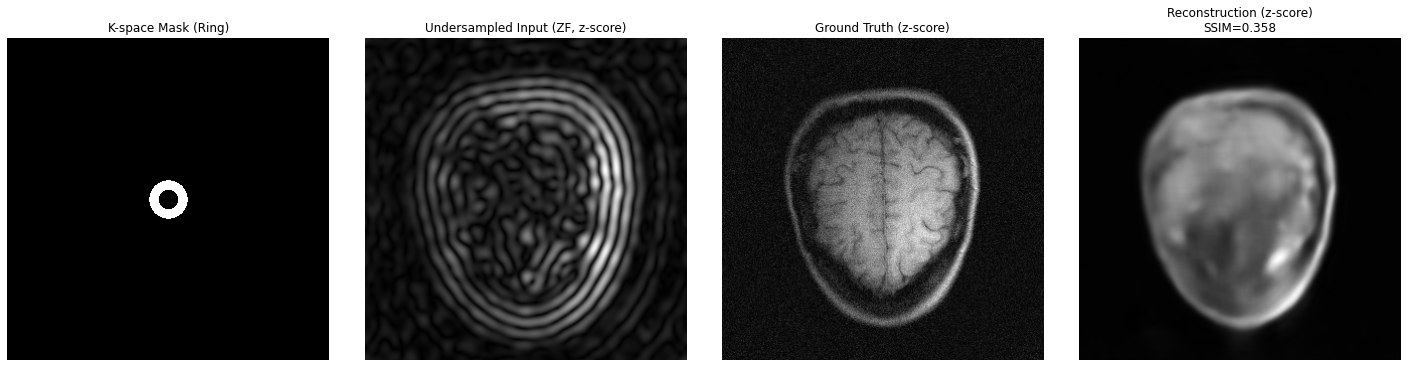

In [30]:
def get_valid_sample(dataset, start=0):
    for idx in range(start, len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            return idx, sample
    raise ValueError("No valid sample found.")
transform = DataTransform_UNet(mask_func=mask_func, combine_coil = False)
# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=transform,
    challenge='multicoil',
    num_skip_slice=5,
)
class ValidDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (x, y, m)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def get_valid_samples(dataset, num_samples=100, start=0):
    valid_samples = []
    idx = start

    while len(valid_samples) < num_samples and idx < len(dataset):
        sample = dataset[idx]
        if sample is not None:
            valid_samples.append(sample)  # (x, y, m)
        idx += 1

    if len(valid_samples) < num_samples:
        raise ValueError(f"Only {len(valid_samples)} valid samples found, expected {num_samples}.")

    return valid_samples
# Extract 2000 valid samples from dataset_train
valid_samples = get_valid_samples(dataset_train, num_samples=2000)

# Create a new dataset using these preloaded samples
dataset_train_final = ValidDataset(valid_samples)
# Pick an index to inspect
sample_index = 20

# Retrieve the sample from the dataset
x, y, mask = dataset_train_final[sample_index]  # Assumes __getitem__ returns (input, target, mask)

print(f"[DEBUG] Input shape  (x): {x.shape}")
print(f"[DEBUG] Target shape (y): {y.shape}")
print(f"[DEBUG] Mask shape   : {mask.shape}")

# Plot input (undersampled), ground truth, and mask side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].numpy(), cmap='gray')
axs[0].set_title("Undersampled Input (x)")

axs[1].imshow(y[0].numpy(), cmap='gray')
axs[1].set_title("Ground Truth (y)")

axs[2].imshow(mask[0].numpy(), cmap='gray')
axs[2].set_title("Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
# 90/10 split
n_total = len(dataset_train_final)
n_train = int(0.9 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset_train_final,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=bhsz, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=bhsz, shuffle=False)
logger.log(f"Using device: {device}")
logger.log(f"len dataloader train: {len(dataloader_train)}")
logger.log(f"len dataloader test: {len(dataloader_val)}")


logger.log("\n----------------TRAINING DATA--------------------")
for i, (x, y, m) in enumerate(dataloader_train):
    logger.log(f"\nSample {i+1}:")
    logger.log(f"  Input (x) shape : {x.shape}")
    logger.log(f"  Target (y) shape: {y.shape}")
    logger.log(f"  Mask shape      : {m.shape}")
    break
def visualize_sample_by_index(dataset, sample_index):
    """
    Visualize a single sample from the dataset by index.

    Parameters:
    - dataset: the MRI dataset (e.g., SliceDataset instance)
    - sample_index: integer index of the sample to visualize
    """
    # Fetch the sample
    x, y, m = dataset[sample_index]  # shape: [1, H, W]

    # Convert to NumPy arrays for plotting
    x_img = x.squeeze().cpu().numpy()
    y_img = y.squeeze().cpu().numpy()
    m_img = m.squeeze().cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Undersampled Input")
    axs[0].axis('off')

    axs[1].imshow(y_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(m_img, cmap='gray')
    axs[2].set_title("Undersampling Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
# Pick sample index (e.g., 10)
sample_index = 10

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
# Pick sample index (e.g., 10)
sample_index = 8

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
model_load_path =  f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0607-19-19-45/models/model_final.pt"
output_dir =f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0607-19-17-48/VISUALIZATIONS"
npy_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.npy"
png_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.png"
npy_path = os.path.join(output_dir, npy_filename)
png_save_path = os.path.join(output_dir, png_filename)
model = Unet(
dim=64,
channels=1,         # input is single-channel masked image
out_dim=1,          # output is single-channel reconstructed image
dim_mults=(1, 2, 3, 4),
self_condition=False
).to(device)
learning_rate = 1e-5  # start here
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# use RMSprop as optimizer
weight_decay = 0.0
optimizer = Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# --------------------------
# 3. Loss function
# --------------------------


loss_fn = l1_image_loss  # expects [B, 1, H, W]


# --------------------------
# 3. Scheduler
# --------------------------
step_size = 12
lr_gamma = 0.1 # change in learning rate
scheduler = StepLR(optimizer, step_size, lr_gamma)
grad_cam_path= EXP_PATH / "XAI" / f"ring_1_Top16Channel_Grad-CAM_ups_plot.png"
grad_cam_path.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
# Get one reconstruction
idx_case = 10

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,) 
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_2_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")
idx_case = 20

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,)
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_2_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")

In [31]:
mask_path = "/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_mask/ring_mask_3.npy"
mask_func = RingMaskFunc(mask_path)

[DEBUG] Input shape  (x): torch.Size([1, 320, 320])
[DEBUG] Target shape (y): torch.Size([1, 320, 320])
[DEBUG] Mask shape   : torch.Size([1, 320, 320])


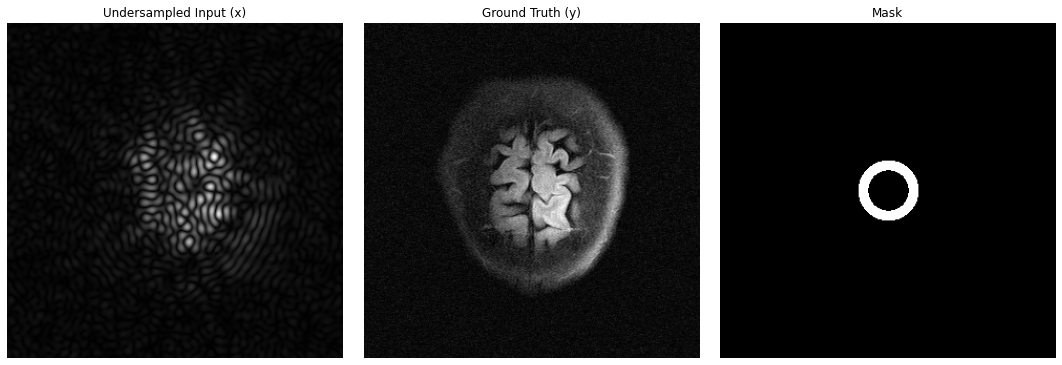

2025-07-18 13:32:06,552 - INFO - Using device: cuda:0
2025-07-18 13:32:06,553 - INFO - len dataloader train: 113
2025-07-18 13:32:06,554 - INFO - len dataloader test: 13
2025-07-18 13:32:06,554 - INFO - 
----------------TRAINING DATA--------------------
2025-07-18 13:32:06,557 - INFO - 
Sample 1:
2025-07-18 13:32:06,557 - INFO -   Input (x) shape : torch.Size([16, 1, 320, 320])
2025-07-18 13:32:06,558 - INFO -   Target (y) shape: torch.Size([16, 1, 320, 320])
2025-07-18 13:32:06,558 - INFO -   Mask shape      : torch.Size([16, 1, 320, 320])


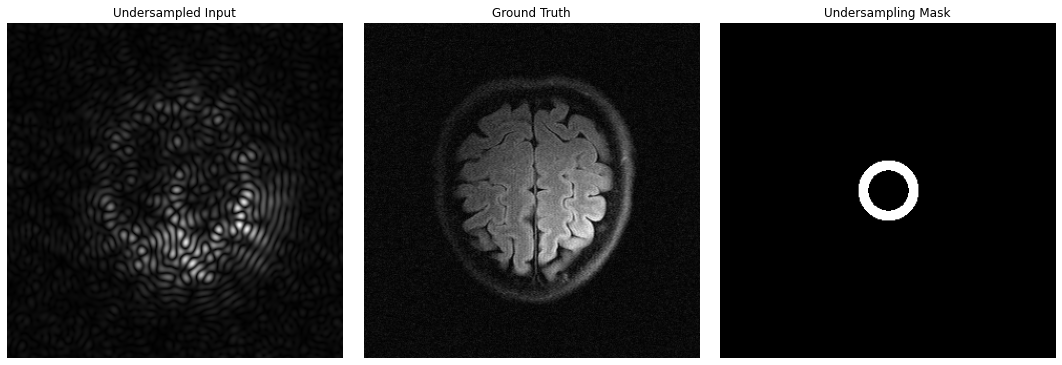

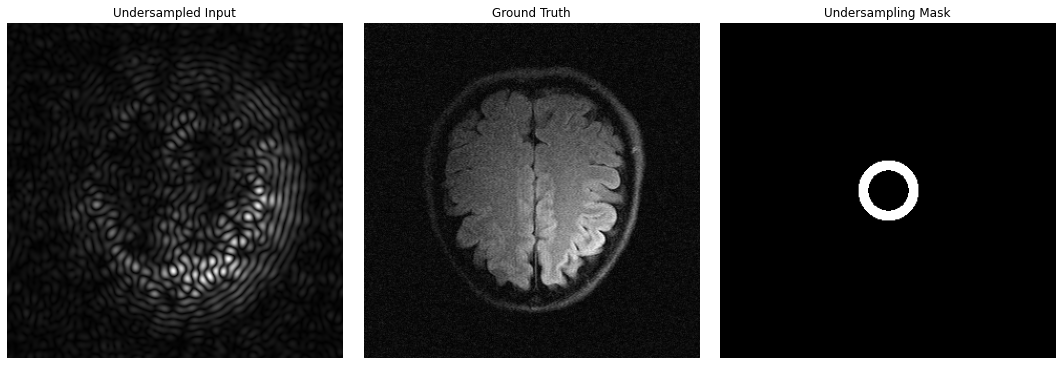

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 5.271012196317315e-05 max: 0.9999107718467712 mean: 0.09079685807228088
y_pred (raw model output) stats: min: -0.023224063217639923 max: 0.951370358467102
Z-score mean: tensor([0.0710, 0.1074, 0.0853, 0.1178, 0.0834, 0.0883, 0.0826, 0.0748, 0.1534,
        0.0949, 0.0867, 0.0659, 0.0774, 0.0802, 0.0687, 0.1150],
       device='cuda:0')
Z-score std: tensor([0.0710, 0.0703, 0.0845, 0.0948, 0.0919, 0.1129, 0.0528, 0.0953, 0.0915,
        0.1063, 0.1064, 0.0970, 0.0946, 0.0886, 0.0866, 0.1110],
       device='cuda:0')
tg (after z-score) stats: min: -1.6682662963867188 max: 17.384098052978516
pred (after z-score) stats: min: -1.32

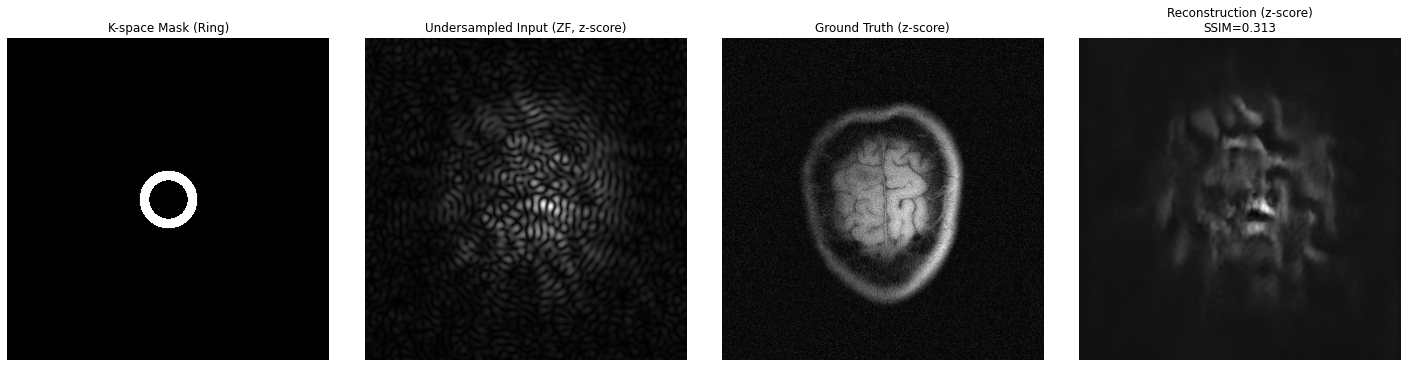

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 1.5415391317219473e-05 max: 0.9999287724494934 mean: 0.10354223102331161
y_pred (raw model output) stats: min: -0.0854351595044136 max: 1.1088200807571411
Z-score mean: tensor([0.0490, 0.0997, 0.1481, 0.0863, 0.1670, 0.0969, 0.0772, 0.0884, 0.0757,
        0.1139, 0.0955, 0.0812, 0.1395, 0.1120, 0.1424, 0.0837],
       device='cuda:0')
Z-score std: tensor([0.0628, 0.1050, 0.1232, 0.0986, 0.

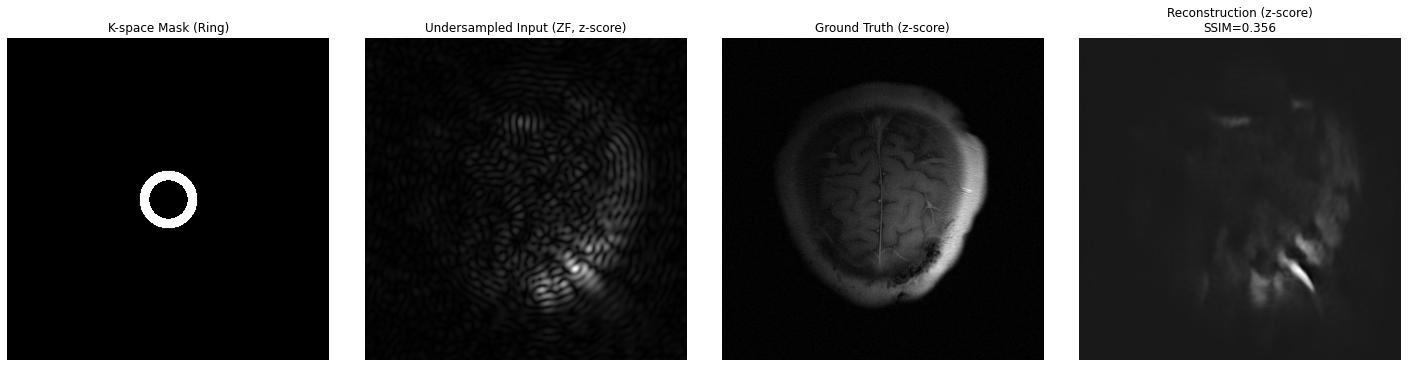

In [32]:
def get_valid_sample(dataset, start=0):
    for idx in range(start, len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            return idx, sample
    raise ValueError("No valid sample found.")
transform = DataTransform_UNet(mask_func=mask_func, combine_coil = False)
# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=transform,
    challenge='multicoil',
    num_skip_slice=5,
)
class ValidDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (x, y, m)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def get_valid_samples(dataset, num_samples=100, start=0):
    valid_samples = []
    idx = start

    while len(valid_samples) < num_samples and idx < len(dataset):
        sample = dataset[idx]
        if sample is not None:
            valid_samples.append(sample)  # (x, y, m)
        idx += 1

    if len(valid_samples) < num_samples:
        raise ValueError(f"Only {len(valid_samples)} valid samples found, expected {num_samples}.")

    return valid_samples
# Extract 2000 valid samples from dataset_train
valid_samples = get_valid_samples(dataset_train, num_samples=2000)

# Create a new dataset using these preloaded samples
dataset_train_final = ValidDataset(valid_samples)
# Pick an index to inspect
sample_index = 20

# Retrieve the sample from the dataset
x, y, mask = dataset_train_final[sample_index]  # Assumes __getitem__ returns (input, target, mask)

print(f"[DEBUG] Input shape  (x): {x.shape}")
print(f"[DEBUG] Target shape (y): {y.shape}")
print(f"[DEBUG] Mask shape   : {mask.shape}")

# Plot input (undersampled), ground truth, and mask side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].numpy(), cmap='gray')
axs[0].set_title("Undersampled Input (x)")

axs[1].imshow(y[0].numpy(), cmap='gray')
axs[1].set_title("Ground Truth (y)")

axs[2].imshow(mask[0].numpy(), cmap='gray')
axs[2].set_title("Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
# 90/10 split
n_total = len(dataset_train_final)
n_train = int(0.9 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset_train_final,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=bhsz, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=bhsz, shuffle=False)
logger.log(f"Using device: {device}")
logger.log(f"len dataloader train: {len(dataloader_train)}")
logger.log(f"len dataloader test: {len(dataloader_val)}")


logger.log("\n----------------TRAINING DATA--------------------")
for i, (x, y, m) in enumerate(dataloader_train):
    logger.log(f"\nSample {i+1}:")
    logger.log(f"  Input (x) shape : {x.shape}")
    logger.log(f"  Target (y) shape: {y.shape}")
    logger.log(f"  Mask shape      : {m.shape}")
    break
def visualize_sample_by_index(dataset, sample_index):
    """
    Visualize a single sample from the dataset by index.

    Parameters:
    - dataset: the MRI dataset (e.g., SliceDataset instance)
    - sample_index: integer index of the sample to visualize
    """
    # Fetch the sample
    x, y, m = dataset[sample_index]  # shape: [1, H, W]

    # Convert to NumPy arrays for plotting
    x_img = x.squeeze().cpu().numpy()
    y_img = y.squeeze().cpu().numpy()
    m_img = m.squeeze().cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Undersampled Input")
    axs[0].axis('off')

    axs[1].imshow(y_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(m_img, cmap='gray')
    axs[2].set_title("Undersampling Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
# Pick sample index (e.g., 10)
sample_index = 10

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
# Pick sample index (e.g., 10)
sample_index = 8

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
model_load_path =  f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0607-19-17-48/models/model_final.pt"
output_dir =f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0612-14-28-02/VISUALIZATIONS"
npy_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.npy"
png_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.png"
npy_path = os.path.join(output_dir, npy_filename)
png_save_path = os.path.join(output_dir, png_filename)
model = Unet(
dim=64,
channels=1,         # input is single-channel masked image
out_dim=1,          # output is single-channel reconstructed image
dim_mults=(1, 2, 3, 4),
self_condition=False
).to(device)
learning_rate = 1e-5  # start here
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# use RMSprop as optimizer
weight_decay = 0.0
optimizer = Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# --------------------------
# 3. Loss function
# --------------------------


loss_fn = l1_image_loss  # expects [B, 1, H, W]


# --------------------------
# 3. Scheduler
# --------------------------
step_size = 12
lr_gamma = 0.1 # change in learning rate
scheduler = StepLR(optimizer, step_size, lr_gamma)
grad_cam_path= EXP_PATH / "XAI" / f"ring_3_Top16Channel_Grad-CAM_ups_plot.png"
grad_cam_path.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
# Get one reconstruction
idx_case = 10

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,) 
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_3_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")
idx_case = 20

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,)
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_3_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")

In [33]:
mask_path = "/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_mask/ring_mask_4.npy"
mask_func = RingMaskFunc(mask_path)

[DEBUG] Input shape  (x): torch.Size([1, 320, 320])
[DEBUG] Target shape (y): torch.Size([1, 320, 320])
[DEBUG] Mask shape   : torch.Size([1, 320, 320])


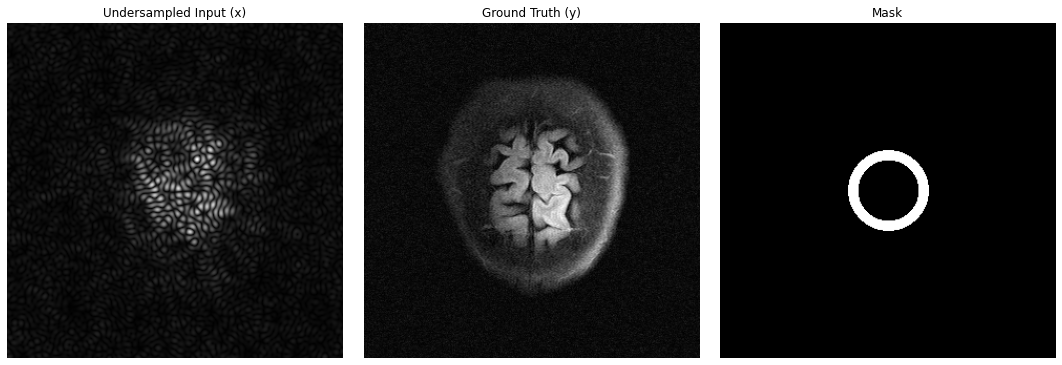

2025-07-18 13:34:20,976 - INFO - Using device: cuda:0
2025-07-18 13:34:20,976 - INFO - len dataloader train: 113
2025-07-18 13:34:20,976 - INFO - len dataloader test: 13
2025-07-18 13:34:20,977 - INFO - 
----------------TRAINING DATA--------------------
2025-07-18 13:34:20,979 - INFO - 
Sample 1:
2025-07-18 13:34:20,979 - INFO -   Input (x) shape : torch.Size([16, 1, 320, 320])
2025-07-18 13:34:20,980 - INFO -   Target (y) shape: torch.Size([16, 1, 320, 320])
2025-07-18 13:34:20,980 - INFO -   Mask shape      : torch.Size([16, 1, 320, 320])


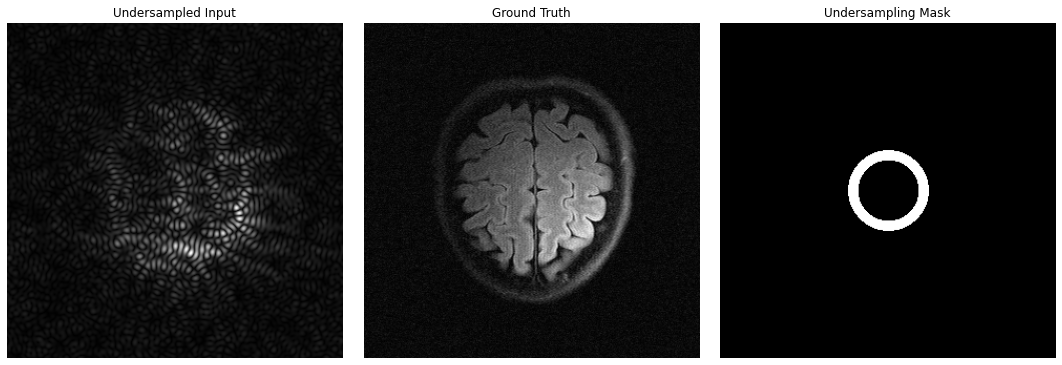

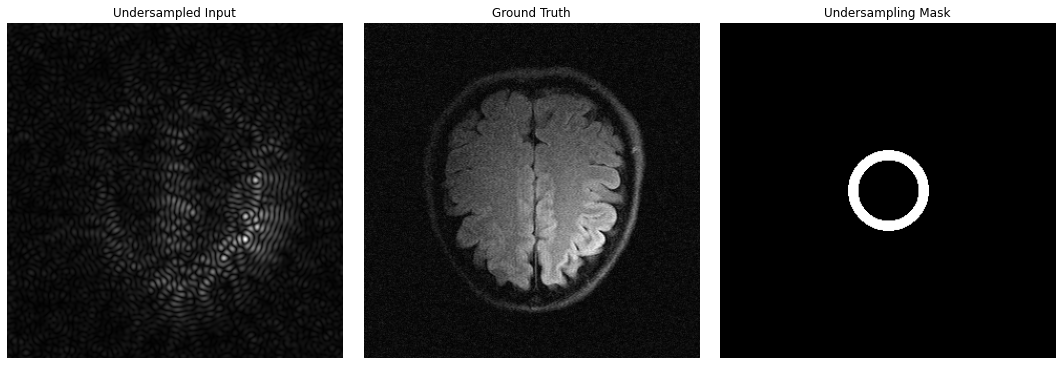

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 2.5441051548114046e-05 max: 0.9999449253082275 mean: 0.09789584577083588
y_pred (raw model output) stats: min: -0.0028598979115486145 max: 0.984097957611084
Z-score mean: tensor([0.0968, 0.0567, 0.0973, 0.0634, 0.0792, 0.0884, 0.0446, 0.0523, 0.0614,
        0.2524, 0.0975, 0.0858, 0.0576, 0.2561, 0.1333, 0.0438],
       device='cuda:0')
Z-score std: tensor([0.0817, 0.0470, 0.1161, 0.0888, 0.0947, 0.0996, 0.0510, 0.0571, 0.0685,
        0.1345, 0.0949, 0.0955, 0.0547, 0.1351, 0.0894, 0.0521],
       device='cuda:0')
tg (after z-score) stats: min: -1.8905282020568848 max: 20.058229446411133
pred (after z-score) stats: min: -0.

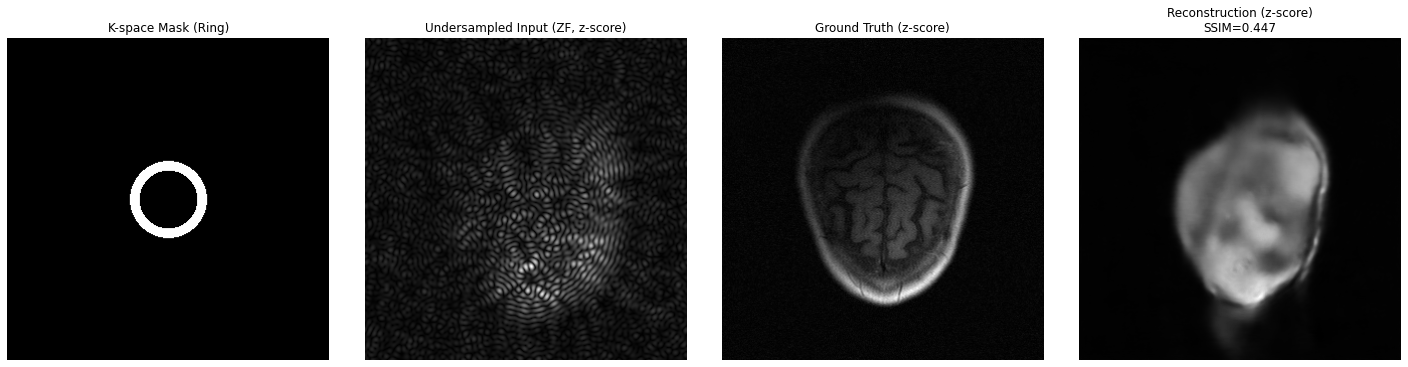

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 5.5486467317678034e-05 max: 0.9999263286590576 mean: 0.09485580027103424
y_pred (raw model output) stats: min: -0.0032141879200935364 max: 1.0203272104263306
Z-score mean: tensor([0.1118, 0.1482, 0.0452, 0.0756, 0.0701, 0.0414, 0.1209, 0.1193, 0.0737,
        0.1451, 0.0984, 0.0531, 0.0509, 0.1610, 0.0757, 0.1272],
       device='cuda:0')
Z-score std: tensor([0.0886, 0.0890, 0.0626, 0.0676,

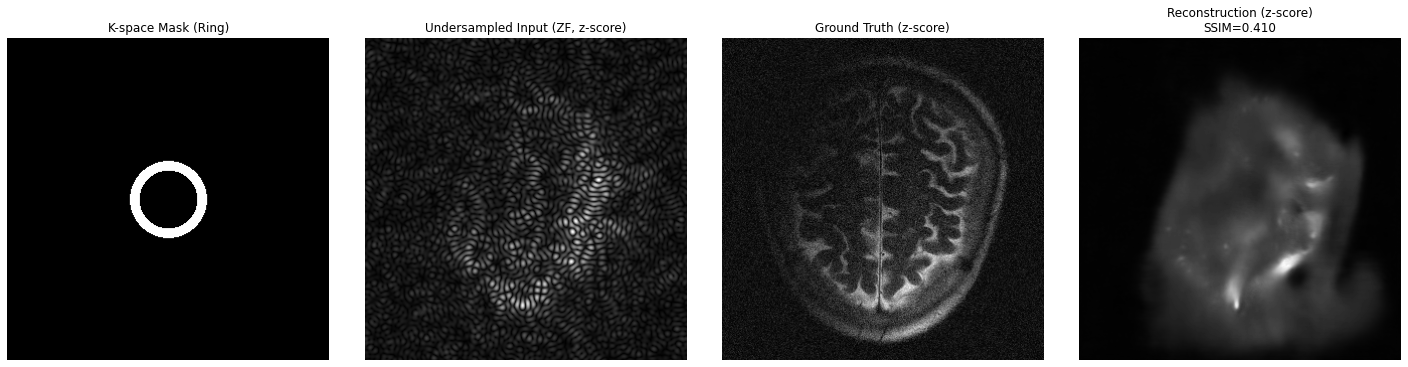

In [34]:
def get_valid_sample(dataset, start=0):
    for idx in range(start, len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            return idx, sample
    raise ValueError("No valid sample found.")
transform = DataTransform_UNet(mask_func=mask_func, combine_coil = False)
# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=transform,
    challenge='multicoil',
    num_skip_slice=5,
)
class ValidDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (x, y, m)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def get_valid_samples(dataset, num_samples=100, start=0):
    valid_samples = []
    idx = start

    while len(valid_samples) < num_samples and idx < len(dataset):
        sample = dataset[idx]
        if sample is not None:
            valid_samples.append(sample)  # (x, y, m)
        idx += 1

    if len(valid_samples) < num_samples:
        raise ValueError(f"Only {len(valid_samples)} valid samples found, expected {num_samples}.")

    return valid_samples
# Extract 2000 valid samples from dataset_train
valid_samples = get_valid_samples(dataset_train, num_samples=2000)

# Create a new dataset using these preloaded samples
dataset_train_final = ValidDataset(valid_samples)
# Pick an index to inspect
sample_index = 20

# Retrieve the sample from the dataset
x, y, mask = dataset_train_final[sample_index]  # Assumes __getitem__ returns (input, target, mask)

print(f"[DEBUG] Input shape  (x): {x.shape}")
print(f"[DEBUG] Target shape (y): {y.shape}")
print(f"[DEBUG] Mask shape   : {mask.shape}")

# Plot input (undersampled), ground truth, and mask side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].numpy(), cmap='gray')
axs[0].set_title("Undersampled Input (x)")

axs[1].imshow(y[0].numpy(), cmap='gray')
axs[1].set_title("Ground Truth (y)")

axs[2].imshow(mask[0].numpy(), cmap='gray')
axs[2].set_title("Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
# 90/10 split
n_total = len(dataset_train_final)
n_train = int(0.9 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset_train_final,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=bhsz, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=bhsz, shuffle=False)
logger.log(f"Using device: {device}")
logger.log(f"len dataloader train: {len(dataloader_train)}")
logger.log(f"len dataloader test: {len(dataloader_val)}")


logger.log("\n----------------TRAINING DATA--------------------")
for i, (x, y, m) in enumerate(dataloader_train):
    logger.log(f"\nSample {i+1}:")
    logger.log(f"  Input (x) shape : {x.shape}")
    logger.log(f"  Target (y) shape: {y.shape}")
    logger.log(f"  Mask shape      : {m.shape}")
    break
def visualize_sample_by_index(dataset, sample_index):
    """
    Visualize a single sample from the dataset by index.

    Parameters:
    - dataset: the MRI dataset (e.g., SliceDataset instance)
    - sample_index: integer index of the sample to visualize
    """
    # Fetch the sample
    x, y, m = dataset[sample_index]  # shape: [1, H, W]

    # Convert to NumPy arrays for plotting
    x_img = x.squeeze().cpu().numpy()
    y_img = y.squeeze().cpu().numpy()
    m_img = m.squeeze().cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Undersampled Input")
    axs[0].axis('off')

    axs[1].imshow(y_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(m_img, cmap='gray')
    axs[2].set_title("Undersampling Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
# Pick sample index (e.g., 10)
sample_index = 10

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
# Pick sample index (e.g., 10)
sample_index = 8

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
model_load_path =  f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0612-14-28-37/models/model_final.pt"
output_dir =f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0612-14-28-37/VISUALIZATIONS"
npy_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.npy"
png_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.png"
npy_path = os.path.join(output_dir, npy_filename)
png_save_path = os.path.join(output_dir, png_filename)
model = Unet(
dim=64,
channels=1,         # input is single-channel masked image
out_dim=1,          # output is single-channel reconstructed image
dim_mults=(1, 2, 3, 4),
self_condition=False
).to(device)
learning_rate = 1e-5  # start here
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# use RMSprop as optimizer
weight_decay = 0.0
optimizer = Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# --------------------------
# 3. Loss function
# --------------------------


loss_fn = l1_image_loss  # expects [B, 1, H, W]


# --------------------------
# 3. Scheduler
# --------------------------
step_size = 12
lr_gamma = 0.1 # change in learning rate
scheduler = StepLR(optimizer, step_size, lr_gamma)
grad_cam_path= EXP_PATH / "XAI" / f"ring_4_Top16Channel_Grad-CAM_ups_plot.png"
grad_cam_path.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
# Get one reconstruction
idx_case = 10

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,) 
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_4_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")
idx_case = 20

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,)
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_4_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")

In [35]:
mask_path = "/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_mask/ring_mask_5.npy"
mask_func = RingMaskFunc(mask_path)

[DEBUG] Input shape  (x): torch.Size([1, 320, 320])
[DEBUG] Target shape (y): torch.Size([1, 320, 320])
[DEBUG] Mask shape   : torch.Size([1, 320, 320])


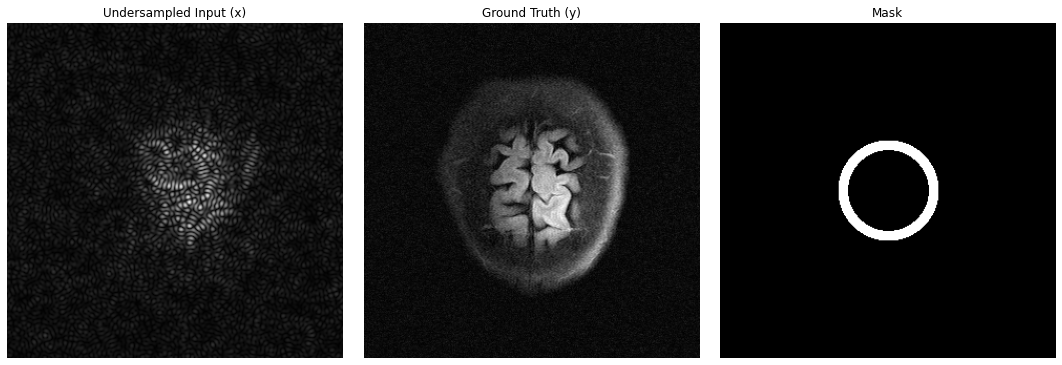

2025-07-18 13:36:40,052 - INFO - Using device: cuda:0
2025-07-18 13:36:40,053 - INFO - len dataloader train: 113
2025-07-18 13:36:40,054 - INFO - len dataloader test: 13
2025-07-18 13:36:40,054 - INFO - 
----------------TRAINING DATA--------------------
2025-07-18 13:36:40,056 - INFO - 
Sample 1:
2025-07-18 13:36:40,057 - INFO -   Input (x) shape : torch.Size([16, 1, 320, 320])
2025-07-18 13:36:40,058 - INFO -   Target (y) shape: torch.Size([16, 1, 320, 320])
2025-07-18 13:36:40,059 - INFO -   Mask shape      : torch.Size([16, 1, 320, 320])


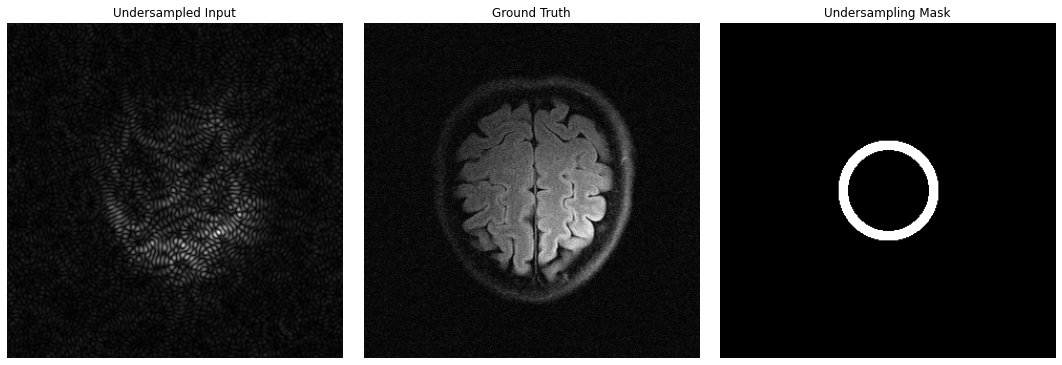

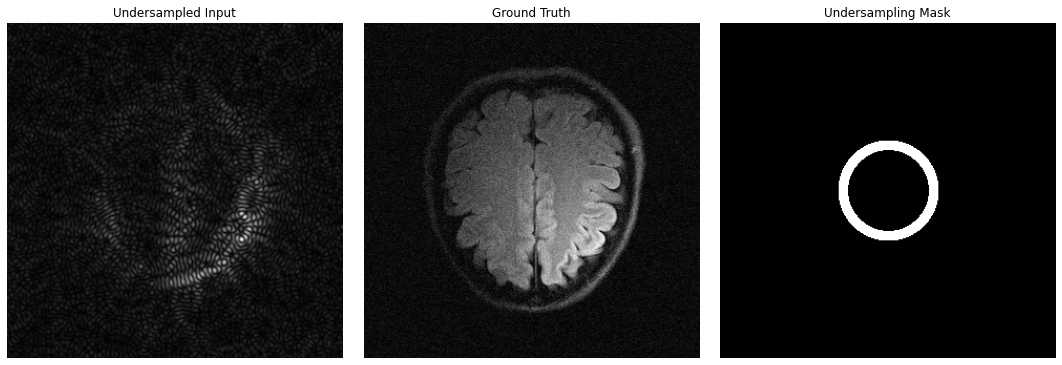

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 3.0003047868376598e-05 max: 0.999930739402771 mean: 0.10340459644794464
y_pred (raw model output) stats: min: 0.0008857622742652893 max: 0.983462393283844
Z-score mean: tensor([0.0354, 0.0584, 0.1785, 0.0636, 0.2025, 0.0932, 0.0517, 0.0874, 0.0427,
        0.0483, 0.1386, 0.1794, 0.1124, 0.0922, 0.0734, 0.1967],
       device='cuda:0')
Z-score std: tensor([0.0433, 0.0621, 0.1035, 0.0614, 0.1058, 0.0830, 0.0476, 0.0955, 0.0547,
        0.0463, 0.0787, 0.1022, 0.1016, 0.0805, 0.0529, 0.1058],
       device='cuda:0')
tg (after z-score) stats: min: -1.9112428426742554 max: 22.264558792114258
pred (after z-score) stats: min: -1.00

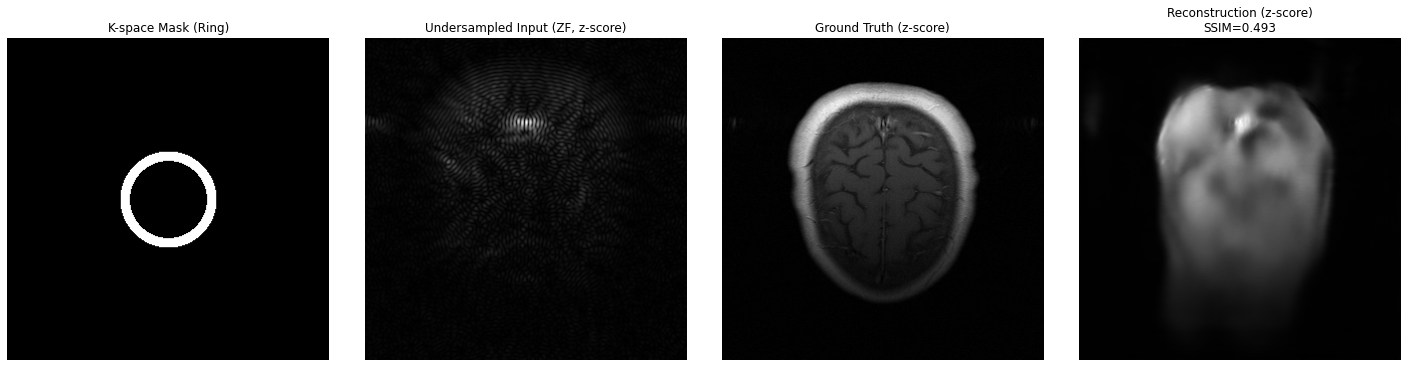

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 5.464724381454289e-05 max: 0.9998812675476074 mean: 0.12033868581056595
y_pred (raw model output) stats: min: 0.010136604309082031 max: 0.9730803370475769
Z-score mean: tensor([0.0520, 0.0828, 0.2429, 0.1261, 0.0491, 0.2543, 0.0643, 0.0766, 0.1016,
        0.0903, 0.1854, 0.0925, 0.1376, 0.0574, 0.1257, 0.1868],
       device='cuda:0')
Z-score std: tensor([0.0517, 0.0950, 0.1298, 0.0798, 0.

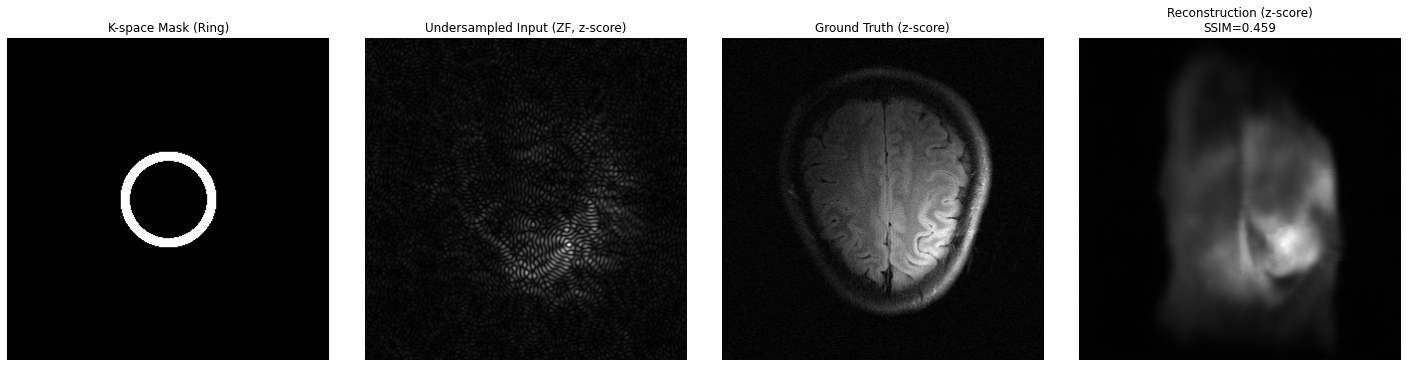

In [36]:
def get_valid_sample(dataset, start=0):
    for idx in range(start, len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            return idx, sample
    raise ValueError("No valid sample found.")
transform = DataTransform_UNet(mask_func=mask_func, combine_coil = False)
# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=transform,
    challenge='multicoil',
    num_skip_slice=5,
)
class ValidDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (x, y, m)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def get_valid_samples(dataset, num_samples=100, start=0):
    valid_samples = []
    idx = start

    while len(valid_samples) < num_samples and idx < len(dataset):
        sample = dataset[idx]
        if sample is not None:
            valid_samples.append(sample)  # (x, y, m)
        idx += 1

    if len(valid_samples) < num_samples:
        raise ValueError(f"Only {len(valid_samples)} valid samples found, expected {num_samples}.")

    return valid_samples
# Extract 2000 valid samples from dataset_train
valid_samples = get_valid_samples(dataset_train, num_samples=2000)

# Create a new dataset using these preloaded samples
dataset_train_final = ValidDataset(valid_samples)
# Pick an index to inspect
sample_index = 20

# Retrieve the sample from the dataset
x, y, mask = dataset_train_final[sample_index]  # Assumes __getitem__ returns (input, target, mask)

print(f"[DEBUG] Input shape  (x): {x.shape}")
print(f"[DEBUG] Target shape (y): {y.shape}")
print(f"[DEBUG] Mask shape   : {mask.shape}")

# Plot input (undersampled), ground truth, and mask side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].numpy(), cmap='gray')
axs[0].set_title("Undersampled Input (x)")

axs[1].imshow(y[0].numpy(), cmap='gray')
axs[1].set_title("Ground Truth (y)")

axs[2].imshow(mask[0].numpy(), cmap='gray')
axs[2].set_title("Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
# 90/10 split
n_total = len(dataset_train_final)
n_train = int(0.9 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset_train_final,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=bhsz, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=bhsz, shuffle=False)
logger.log(f"Using device: {device}")
logger.log(f"len dataloader train: {len(dataloader_train)}")
logger.log(f"len dataloader test: {len(dataloader_val)}")


logger.log("\n----------------TRAINING DATA--------------------")
for i, (x, y, m) in enumerate(dataloader_train):
    logger.log(f"\nSample {i+1}:")
    logger.log(f"  Input (x) shape : {x.shape}")
    logger.log(f"  Target (y) shape: {y.shape}")
    logger.log(f"  Mask shape      : {m.shape}")
    break
def visualize_sample_by_index(dataset, sample_index):
    """
    Visualize a single sample from the dataset by index.

    Parameters:
    - dataset: the MRI dataset (e.g., SliceDataset instance)
    - sample_index: integer index of the sample to visualize
    """
    # Fetch the sample
    x, y, m = dataset[sample_index]  # shape: [1, H, W]

    # Convert to NumPy arrays for plotting
    x_img = x.squeeze().cpu().numpy()
    y_img = y.squeeze().cpu().numpy()
    m_img = m.squeeze().cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Undersampled Input")
    axs[0].axis('off')

    axs[1].imshow(y_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(m_img, cmap='gray')
    axs[2].set_title("Undersampling Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
# Pick sample index (e.g., 10)
sample_index = 10

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
# Pick sample index (e.g., 10)
sample_index = 8

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
model_load_path =  f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0616-10-18-43/models/model_final.pt"
output_dir =f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0616-10-18-43/VISUALIZATIONS"
npy_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.npy"
png_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.png"
npy_path = os.path.join(output_dir, npy_filename)
png_save_path = os.path.join(output_dir, png_filename)
model = Unet(
dim=64,
channels=1,         # input is single-channel masked image
out_dim=1,          # output is single-channel reconstructed image
dim_mults=(1, 2, 3, 4),
self_condition=False
).to(device)
learning_rate = 1e-5  # start here
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# use RMSprop as optimizer
weight_decay = 0.0
optimizer = Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# --------------------------
# 3. Loss function
# --------------------------


loss_fn = l1_image_loss  # expects [B, 1, H, W]


# --------------------------
# 3. Scheduler
# --------------------------
step_size = 12
lr_gamma = 0.1 # change in learning rate
scheduler = StepLR(optimizer, step_size, lr_gamma)
grad_cam_path= EXP_PATH / "XAI" / f"ring_1_Top16Channel_Grad-CAM_ups_plot.png"
grad_cam_path.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
# Get one reconstruction
idx_case = 10

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,) 
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_5_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")
idx_case = 20

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,)
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_5_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")

In [37]:
mask_path = "/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_mask/ring_mask_6.npy"
mask_func = RingMaskFunc(mask_path)

[DEBUG] Input shape  (x): torch.Size([1, 320, 320])
[DEBUG] Target shape (y): torch.Size([1, 320, 320])
[DEBUG] Mask shape   : torch.Size([1, 320, 320])


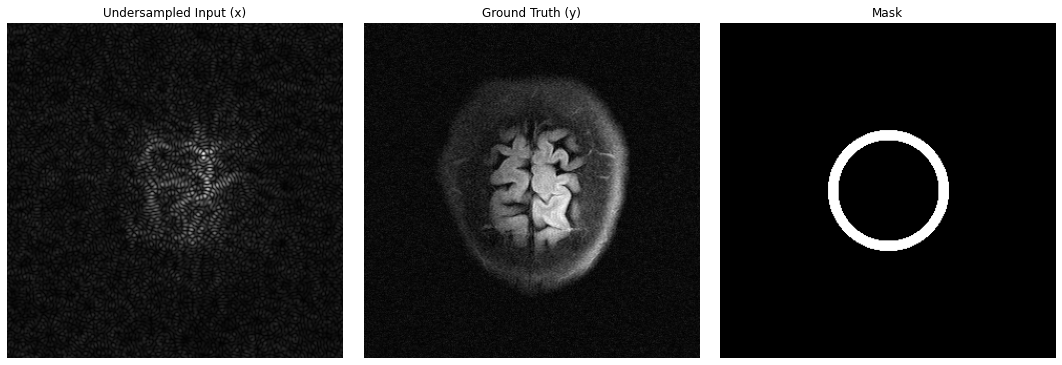

2025-07-18 13:38:58,515 - INFO - Using device: cuda:0
2025-07-18 13:38:58,524 - INFO - len dataloader train: 113
2025-07-18 13:38:58,524 - INFO - len dataloader test: 13
2025-07-18 13:38:58,525 - INFO - 
----------------TRAINING DATA--------------------
2025-07-18 13:38:58,527 - INFO - 
Sample 1:
2025-07-18 13:38:58,528 - INFO -   Input (x) shape : torch.Size([16, 1, 320, 320])
2025-07-18 13:38:58,529 - INFO -   Target (y) shape: torch.Size([16, 1, 320, 320])
2025-07-18 13:38:58,529 - INFO -   Mask shape      : torch.Size([16, 1, 320, 320])


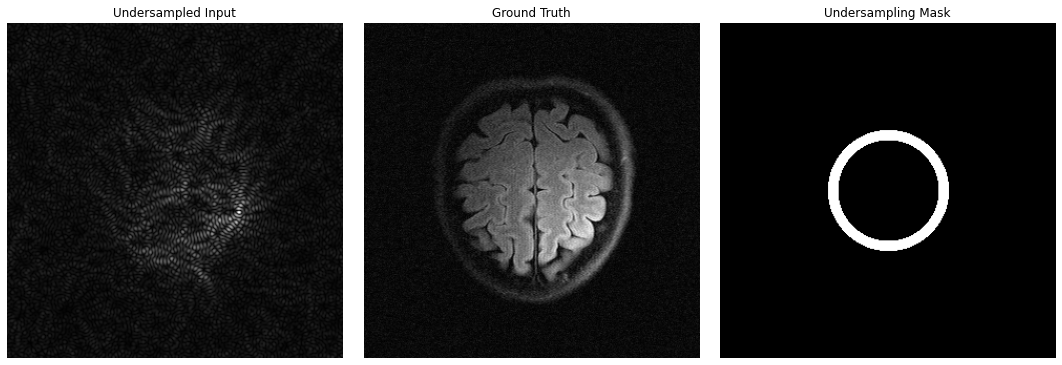

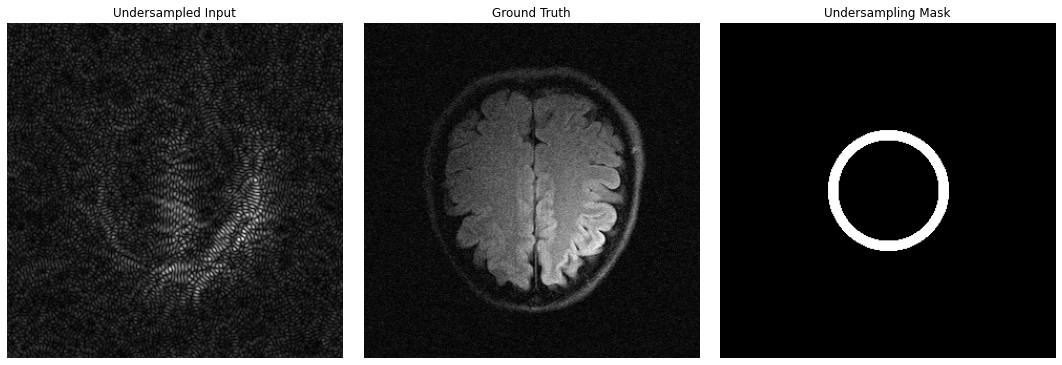

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 1.4380853826878592e-05 max: 0.9999030828475952 mean: 0.14467714726924896
y_pred (raw model output) stats: min: 0.004968978464603424 max: 0.8444128632545471
Z-score mean: tensor([0.1933, 0.0751, 0.2499, 0.0505, 0.2196, 0.1967, 0.0865, 0.0538, 0.1040,
        0.0542, 0.1026, 0.2566, 0.2198, 0.1223, 0.2561, 0.0739],
       device='cuda:0')
Z-score std: tensor([0.1054, 0.0636, 0.1307, 0.0570, 0.1156, 0.1033, 0.0726, 0.0466, 0.0846,
        0.0552, 0.0772, 0.1347, 0.1172, 0.0901, 0.1341, 0.0701],
       device='cuda:0')
tg (after z-score) stats: min: -1.9100416898727417 max: 20.325538635253906
pred (after z-score) stats: min: -1.1

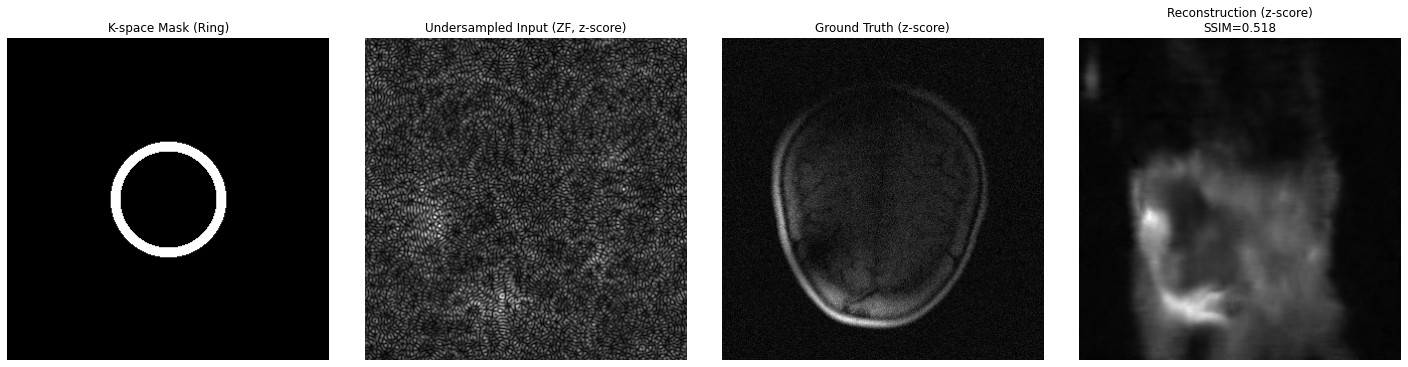

Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Inside model evaluation
Prediction
pred:  torch.Size([16, 320, 320])
=== [recon_slice_unet] ===
X (input to model) stats: min: 4.0090952097671106e-05 max: 0.9999022483825684 mean: 0.11115368455648422
y_pred (raw model output) stats: min: 0.005488239228725433 max: 1.016332745552063
Z-score mean: tensor([0.1102, 0.0565, 0.0893, 0.0471, 0.2103, 0.1038, 0.1123, 0.0793, 0.0618,
        0.0551, 0.1883, 0.0747, 0.0458, 0.0820, 0.1776, 0.2844],
       device='cuda:0')
Z-score std: tensor([0.0901, 0.0595, 0.0811, 0.0509, 0.

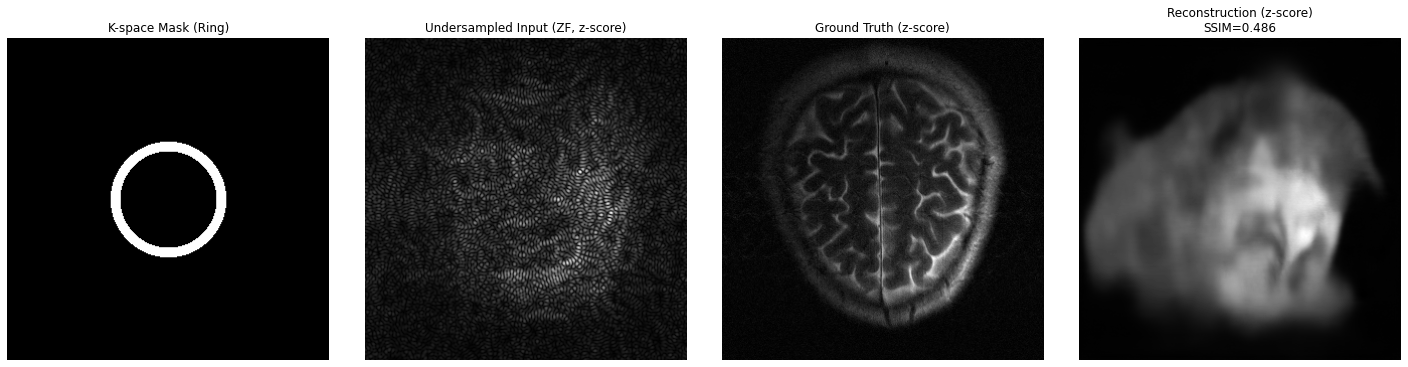

In [38]:
def get_valid_sample(dataset, start=0):
    for idx in range(start, len(dataset)):
        sample = dataset[idx]
        if sample is not None:
            return idx, sample
    raise ValueError("No valid sample found.")
transform = DataTransform_UNet(mask_func=mask_func, combine_coil = False)
# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=transform,
    challenge='multicoil',
    num_skip_slice=5,
)
class ValidDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (x, y, m)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def get_valid_samples(dataset, num_samples=100, start=0):
    valid_samples = []
    idx = start

    while len(valid_samples) < num_samples and idx < len(dataset):
        sample = dataset[idx]
        if sample is not None:
            valid_samples.append(sample)  # (x, y, m)
        idx += 1

    if len(valid_samples) < num_samples:
        raise ValueError(f"Only {len(valid_samples)} valid samples found, expected {num_samples}.")

    return valid_samples
# Extract 2000 valid samples from dataset_train
valid_samples = get_valid_samples(dataset_train, num_samples=2000)

# Create a new dataset using these preloaded samples
dataset_train_final = ValidDataset(valid_samples)
# Pick an index to inspect
sample_index = 20

# Retrieve the sample from the dataset
x, y, mask = dataset_train_final[sample_index]  # Assumes __getitem__ returns (input, target, mask)

print(f"[DEBUG] Input shape  (x): {x.shape}")
print(f"[DEBUG] Target shape (y): {y.shape}")
print(f"[DEBUG] Mask shape   : {mask.shape}")

# Plot input (undersampled), ground truth, and mask side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x[0].numpy(), cmap='gray')
axs[0].set_title("Undersampled Input (x)")

axs[1].imshow(y[0].numpy(), cmap='gray')
axs[1].set_title("Ground Truth (y)")

axs[2].imshow(mask[0].numpy(), cmap='gray')
axs[2].set_title("Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
# 90/10 split
n_total = len(dataset_train_final)
n_train = int(0.9 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset_train_final,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=bhsz, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=bhsz, shuffle=False)
logger.log(f"Using device: {device}")
logger.log(f"len dataloader train: {len(dataloader_train)}")
logger.log(f"len dataloader test: {len(dataloader_val)}")


logger.log("\n----------------TRAINING DATA--------------------")
for i, (x, y, m) in enumerate(dataloader_train):
    logger.log(f"\nSample {i+1}:")
    logger.log(f"  Input (x) shape : {x.shape}")
    logger.log(f"  Target (y) shape: {y.shape}")
    logger.log(f"  Mask shape      : {m.shape}")
    break
def visualize_sample_by_index(dataset, sample_index):
    """
    Visualize a single sample from the dataset by index.

    Parameters:
    - dataset: the MRI dataset (e.g., SliceDataset instance)
    - sample_index: integer index of the sample to visualize
    """
    # Fetch the sample
    x, y, m = dataset[sample_index]  # shape: [1, H, W]

    # Convert to NumPy arrays for plotting
    x_img = x.squeeze().cpu().numpy()
    y_img = y.squeeze().cpu().numpy()
    m_img = m.squeeze().cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Undersampled Input")
    axs[0].axis('off')

    axs[1].imshow(y_img, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(m_img, cmap='gray')
    axs[2].set_title("Undersampling Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
# Pick sample index (e.g., 10)
sample_index = 10

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
# Pick sample index (e.g., 10)
sample_index = 8

# Visualize from training dataset (or val/test)
visualize_sample_by_index(dataset_train, sample_index)
model_load_path =  f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0711-09-12-33/models/model_final.pt"
output_dir =f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/0711-09-12-33/VISUALIZATIONS"
npy_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.npy"
png_filename = f"test_sample_singlecoil_reconstruction_idx_{idx_case}_model_final.png"
npy_path = os.path.join(output_dir, npy_filename)
png_save_path = os.path.join(output_dir, png_filename)
model = Unet(
dim=64,
channels=1,         # input is single-channel masked image
out_dim=1,          # output is single-channel reconstructed image
dim_mults=(1, 2, 3, 4),
self_condition=False
).to(device)
learning_rate = 1e-5  # start here
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
checkpoint = torch.load(model_load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# use RMSprop as optimizer
weight_decay = 0.0
optimizer = Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# --------------------------
# 3. Loss function
# --------------------------


loss_fn = l1_image_loss  # expects [B, 1, H, W]


# --------------------------
# 3. Scheduler
# --------------------------
step_size = 12
lr_gamma = 0.1 # change in learning rate
scheduler = StepLR(optimizer, step_size, lr_gamma)
grad_cam_path= EXP_PATH / "XAI" / f"ring_6_Top16Channel_Grad-CAM_ups_plot.png"
grad_cam_path.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
# Get one reconstruction
idx_case = 10

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,) 
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_6_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")
idx_case = 20

pred, zf, tg, i_nmse, i_psnr, i_ssim, mask, X_for_gradcam = recon_slice_unet(
dataloader=dataloader_train,  # Define this earlier
net=model,
device=device,
idx_case=idx_case,)
plot_full_reconstruction_4panel(
    pred=pred[0],
    zf=zf[0],
    gt=tg[0],
    mask=mask[0][0],  # assuming shape is [B, 1, H, W]
    ssim_value=i_ssim, save_path = f"/data2/users/koushani/FAST_MRI_data/checkpoint_dir/Axial/SuperMap_RandomGaussian_Mask/ring_6_sample_{idx_case}_BrainData_model_FullPanel_reconstruction_plot.png")